#### Imports

In [1]:
#https://forecastegy.com/posts/time-series-clustering-python-scikit-learn/
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly.express as px
import plotly.graph_objects as go
from openbb import obb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans, DBSCAN
import polygon

In [2]:
from fredapi import Fred
fred_api_key = 'd640e0a4f2d8bdf668b5dad55d9b4ca6'
fred = Fred(api_key=fred_api_key)
# Now you can make FRED API requests using 'fred'


#### Read in market data

In [3]:
def create_dataframe():
    #ewa = australia, ewc = canada, inda = india, ewj = japan, ewl = switzerland, ewu = United Kingdom, eusa = USA, ewy = South Korea
	symbols = ['spy','ewa','ewz','ieur','ewc','inda','ewj','ewl','ewu','ewy']  #'i:fvx', 'i:tyx'
	start_date = '2020-01-03'
	mp = 7
	timespan = 'day'
	for symbol in symbols:
		tdf = polygon.get_data(start_date, symbol, timespan=timespan, multiplier=mp, silent=False)
		columns = tdf.columns.tolist()
		for col in columns:
			tdf.rename(columns={col: "%s_%s"%(symbol.lower(), col)}, inplace=True)
        	# Merge each instrument data into a master dataframe
			#check to see if date_time is in the columns and if not, pass
			#df = pd.merge_asof(df, tdf, left_index=True, right_index=True)
		if 'df' not in locals():
			# If df does not exist, create a new DataFrame named df
			df = tdf
		else:
			df = pd.concat([df, tdf], axis=1)
		# If df exists, concatenate tdf to df		
	#string_to_check = 'close'
	#columns_to_delete = [col for col in df.columns if 'close' not in col and 'volume' not in col]
	#df.drop(columns=columns_to_delete, inplace=True)
	return df

In [4]:
#possible ideas for Kmeans clustering of data.  
# https://medium.com/the-quant-journey/unsupervised-machine-learning-k-means-clustering-with-applications-in-finance-fbabd3f187f6

In [5]:
df = create_dataframe()

Downloaded SPY: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded SPY: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWA: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded EWA: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWZ: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded EWZ: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded IEUR: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded IEUR: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWC: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded EWC: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded INDA: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded INDA: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWJ: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded EWJ: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWL: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded EWL: 2024-03-02 05:00:00 - 2024-03-02 05:00:00
Downloaded EWU: 2020-01-03 05:00:00 - 2024-03-01 05:00:00
Downloaded

In [6]:
# Create a list of column names that contain 'close'
close_columns = [col for col in df.columns if 'close' in col.lower()]

# Select only these columns from the DataFrame
df_close = df[close_columns]


In [7]:
df_close.head()

,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close
0,512,23.99,32.94,55.99,36.95,51.86,69.8299,46.66,32.71,65.461


In [8]:
df_close.columns

Index(['spy_close', 'ewa_close', 'ewz_close', 'ieur_close', 'ewc_close',
       'inda_close', 'ewj_close', 'ewl_close', 'ewu_close', 'ewy_close'],
      dtype='object')

In [9]:
def compute_past_values(row):
    past_values = {}
    for lag in range(21):
        for col in df.columns:
            past_values[f'{col}_lag_{lag}'] = row[col]
    return pd.Series(past_values)

# Apply the function to each row
#df_close = df.apply(compute_past_values, axis=1)

In [10]:
df_close.head()


,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close
0,512,23.99,32.94,55.99,36.95,51.86,69.8299,46.66,32.71,65.461


In [11]:
df_close.index

RangeIndex(start=0, stop=1, step=1)

In [12]:
# Select only these columns from the DataFrame
df_close_pct = df_close.pct_change().dropna() * 100
df_close_pct.to_parquet('df_diff.parquet', engine='pyarrow')

#### Set the country column as the index

In [13]:
df_close_pct.head()

,spy_close,ewa_close,ewz_close,ieur_close,ewc_close,inda_close,ewj_close,ewl_close,ewu_close,ewy_close


In [14]:
def pivot_dataframe(df):
    df.index = df.index.astype(str)
    wide_df = df.T

    # Set the first row as column names
    wide_df.columns = df.index
    wide_df.columns = pd.to_datetime(wide_df.columns)
    #wide_df = wide_df[1:]

    # Display the resulting DataFrame
    return wide_df

In [15]:

def create_quarter_dfs(df, equities = True):
    # Create a dictionary to store the DataFrames

    quarter_dfs = {}

    # Extract unique quarters from the index
    df.index = pd.to_datetime(df.index)
    unique_quarters = df.index.to_period('Q').unique()

    # Iterate through each unique quarter
    for quarter in unique_quarters:
        # Filter the DataFrame for the current quarter
        quarter_df = df[df.index.to_period('Q') == quarter]
        quarter_df = pivot_dataframe(quarter_df)
        
        row_names = {'spy_close': 'usa','ewa_close': 'australia', 'ieur_close':'europe','ewz_close': 'brazil','ewc_close':'canada', 'inda_close': 'india',
                    'ewj_close': 'japan', 'ewl_close': 'switzerland', 'ewu_close': 'uk','ewy_close': 'south korea'}
        if equities:
            quarter_df = quarter_df.rename(index=row_names)
        # Add the DataFrame to the dictionary with the quarter label as the key
        quarter_dfs[str(quarter)] = quarter_df

    return quarter_dfs

# Example usage:
# Assuming your DataFrame is named 'my_df'
quarterly_equities = create_quarter_dfs(df_close_pct)

In [16]:
quarterly_equities


{}

In [17]:
#sns.pairplot(df)

In [18]:
data = pd.DataFrame()
cols_dict = {"GC": "Gold", "HG": "Copper", "CL": "Crude Oil", "ZS": "Soy"}
for symbol in ["GC", "HG", "CL", "ZS"]:
    data[symbol] = (
        obb.derivatives.futures.historical(
            symbol,
            start_date="2019-08-01",
            interval="1wk",
        ).to_df()["close"].rename(symbol)
    )
data.columns = cols_dict.values()
data.index = data.index.strftime("%Y-%m-%d")


In [19]:
bonds = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [20]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'DGS10',  # 10-Year U.S. Treasury Yield
    'canada':'IRLTLT01CAM156N', # 10-Year canadian treasury yield
    'europe': 'IRLTLT01EZM156N',  # 10Y Government Bond Yield for Europe
    'uk': 'IRLTLT01GBM156N', # Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United
    'australia': 'IRLTLT01AUM156N',  # 10-Year Government Bond Yield for Australia
    'brazil': 'INTGSTBRM193N',  # 10-Year Government Bond Yield for Brazil
    'india': 'INDIRLTLT01STM',  # 10-Year Government Bond Yield for India
    'switzerland': 'IRLTLT01CHM156N',  # 10-Year Government Bond Yield for Switzerland
    'japan': 'IRLTLT01JPM156N',  # 10-Year Government Bond Yield for Japan
    'south korea': 'IRLTLT01KRM156N'  # 10-Year Government Bond Yield for South Korea
}

# Fetch data for each country
for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    bonds = pd.merge(bonds, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        bonds[country] = bonds[country].ffill().bfill()
    mask = (bonds.index.day == 1)
    bonds.loc[mask, country] = bonds.loc[mask, country].ffill()


In [21]:
bonds.dropna(inplace=True)
#bonds = bonds.diff().dropna()


In [22]:
bonds.tail()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-09-01,4.18,3.816000,3.5056,4.4199,4.211,11.0936,7.17,1.09,0.765,3.949
2023-10-01,4.59,4.062000,3.7200,4.5695,4.626,10.9877,7.35,1.05,0.950,4.272
2023-11-01,4.77,3.710952,3.4200,4.2721,4.578,11.2829,7.27,0.82,0.660,3.890
2023-12-01,4.22,3.234211,2.8700,3.8600,4.188,10.2410,7.22,0.66,0.585,3.415
2024-01-01,3.88,3.234211,2.8700,3.8600,4.188,10.2410,7.22,0.66,0.585,3.415


In [23]:
quarterly_bonds = create_quarter_dfs(bonds)

In [24]:
overnight_rates = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [25]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'IRSTFR01USQ156N',  # Interest Rates: Immediate Rates (< 24 Hours): Federal Funds Rate: Total for United States
    'canada': 'IRSTCB01CAM156N', # Interest Rates: Immediate Rates canada
    'europe': 'IRSTCI01EZM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Euro Area 
    'uk':'IRSTCI01GBM156N', #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for United Kingdom
    'australia': 'IRSTCI01AUM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Australia
    'brazil': 'IRSTCB01BRM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for Brazil
    'india': 'INDIR3TIB01STM',  # Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for India quarterly
    'switzerland': 'IRSTCI01CHM156N',  #Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Switzerland
    'japan': 'IRSTCI01JPM156N',  #Interest Rates: Immediate Rates (< 24 Hours): Central Bank Rates: Total for Japan
    'south korea': 'INTDSRKRM193N'  #  Interest Rates, Discount Rate for Republic of Korea 
}

# Fetch data for each country

for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    overnight_rates = pd.merge(overnight_rates, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        overnight_rates[country] = overnight_rates[country].ffill().bfill()
    mask = (overnight_rates.index.day == 1)
    overnight_rates.loc[mask, country] = overnight_rates.loc[mask, country].ffill()



In [26]:
overnight_rates = overnight_rates.dropna()

In [27]:
overnight_rates.tail()

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-09-01,5.33,5.25,3.712522,5.1854,4.10,13.08,6.84,1.20,-0.054,2.0
2023-10-01,5.33,5.25,3.901060,5.1871,4.10,12.75,6.89,1.20,-0.020,2.0
2023-11-01,5.33,5.25,3.902744,5.1875,4.29,12.28,6.93,1.63,-0.015,2.0
2023-12-01,5.33,5.25,3.903442,5.1900,4.35,11.96,6.95,1.60,-0.012,2.0
2024-01-01,5.33,5.25,3.903442,5.1900,4.35,11.96,6.95,1.60,-0.012,2.0


In [28]:
quarterly_onr = create_quarter_dfs(overnight_rates)

In [29]:
quarterly_onr['2023Q4'].head(10)

,2023-10-01,2023-11-01,2023-12-01
usa,5.33000,5.330000,5.330000
canada,5.25000,5.250000,5.250000
europe,3.90106,3.902744,3.903442
uk,5.18710,5.187500,5.190000
australia,4.10000,4.290000,4.350000
brazil,12.75000,12.280000,11.960000
india,6.89000,6.930000,6.950000
switzerland,1.20000,1.630000,1.600000
japan,-0.02000,-0.015000,-0.012000
south korea,2.00000,2.000000,2.000000


In [30]:
three_month_rates = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [31]:
# Define the series IDs for government bond yields
series_ids = {
    'usa': 'T10Y3MM',  # Interest Rates: 3mth: Total for United States
    'canada': 'IR3TIB01CAM156N',
    'europe': 'IR3TIB01EZM156N',  #  Interest Rates: Immediate Rates (< 24 Hours): Call Money/Interbank Rate: Total for Euro Area 
    'uk':'IR3TIB01GBM156N', #  Interest Rates: 3mth: Total for United Kingdom
    'australia': 'IR3TBB01AUM156N',  #  Interest Rates: 3mth: Total for Australia
    'brazil': 'INTGSTBRM193N',  #  Interest Rates: 3mnth: Total for Brazil
    'india': 'INDIR3TIB01STM',  # Interest Rates: 3mnth: Total for India quarterly
    'switzerland': 'IR3TIB01CHM156N',  #Interest Rates: 3mnth: Total for Switzerland
    'japan': 'IR3TIB01JPM156N',  #Interest Rates: 3mnth: Total for Japan
    'south korea': 'IR3TCD01KRM156N'  #  Interest Rates, 3mnth for Republic of Korea 
}

# Fetch data for each country

for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    three_month_rates = pd.merge(three_month_rates, country_df, left_index=True, right_index=True, how="left")
    mask = (three_month_rates.index.day == 1)
    three_month_rates.loc[mask, country] = three_month_rates.loc[mask, country].ffill()

In [32]:
three_month_rates = three_month_rates.dropna()

In [33]:
quarterly_3mnth = create_quarter_dfs(three_month_rates)

In [34]:
cpi = pd.DataFrame(index=pd.date_range(start="2019-08-01", end="2024-01-01"))

In [35]:
#consumer prices
series_ids = {
    'usa': 'CPALTT01USM659N',  # consumer inflation prices for USA
    'canada': 'CPALCY01CAM661N', # consumer inflation prices for Canada
    'europe': 'CPHPTT01EZM659N',  # Consumer Price Index: Harmonised Prices: All Items: Total for the Euro Area 
    'uk':'CPALTT01GBM659N', # Inflation, consumer prices for the United Kingdom 
    'australia': 'CPALTT01AUQ659N',  # consumer inflation prices for Australia
    'brazil': 'CPALTT01BRM659N',  # consumer inflation prices for Brazil
    'india': 'CPALTT01INM659N',  # consumer inflation prices for India
    'switzerland': 'CPALTT01CHM659N',  # consumer inflation prices for Switzerland
    'japan': 'CPALTT01JPM659N',  # consumer inflation prices for Japan
    'south korea': 'CPALTT01KRM659N'  # consumer inflation prices for South Korea
}

# Fetch data for each country
consumer_prices = {}
for country, series_id in series_ids.items():
    country_data = fred.get_series(series_id, start="2019-08-01", end="2024-01-01")
    country_df = pd.DataFrame(country_data, columns=[country])
    cpi = pd.merge(cpi, country_df, left_index=True, right_index=True, how="left")
    if country == 'usa':
        cpi[country] = cpi[country].ffill().bfill()
    if country == 'australia':
        cpi[country] = cpi[country].ffill()
    if country == 'japan':
        country_data = fred.get_series('JPNPCPIPCPPPT', start="2021-06-01", end="2024-02-01")
        cpi[country] = country_data
        cpi[country] = cpi[country].ffill().bfill()
    mask = (cpi.index.day == 1)
    cpi.loc[mask, country] = cpi.loc[mask, country].ffill()

In [36]:
cpi.tail(158)

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
2023-07-28,3.177780,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-07-29,3.177780,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-07-30,3.177780,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-07-31,3.177780,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-08-01,3.665112,126.029225,8.7,6.3,5.373832,4.608170,6.912442,1.554305,2.318157,3.415577
...,...,...,...,...,...,...,...,...,...,...
2023-12-28,3.352123,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-12-29,3.352123,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-12-30,3.352123,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN
2023-12-31,3.352123,NaN,NaN,NaN,5.373832,NaN,NaN,NaN,2.318157,NaN


In [37]:
cpi = cpi.dropna()

In [38]:
#cpi = cpi.diff().dropna()

In [39]:
quarterly_cpi = create_quarter_dfs(cpi)
quarterly_cpi['2023Q4'].head(10)

,2023-10-01,2023-11-01,2023-12-01
usa,3.241145,3.137271,3.352123
canada,126.109295,126.189364,126.189364
europe,8.700000,8.700000,8.700000
uk,4.700000,4.200000,4.200000
australia,5.373832,5.373832,5.373832
brazil,4.819185,4.683566,4.683566
india,4.452830,4.981132,4.981132
switzerland,1.693438,1.443668,1.714889
japan,2.318157,2.318157,2.318157
south korea,3.809175,3.336389,3.336389


In [40]:
dict_list = [quarterly_cpi, quarterly_onr, quarterly_bonds, quarterly_3mnth]

# Initialize an empty dictionary to store the merged DataFrames
merged_dict = {}

# Iterate over the keys in the first dictionary
for key in quarterly_cpi.keys():
    # Use a list comprehension to get the DataFrame for the current key from each dictionary
    dfs_to_merge = [d[key] for d in dict_list]
    
    # Use the pandas concat function to merge the DataFrames along the column axis
    merged_dict[key] = pd.concat(dfs_to_merge, axis=1)

In [41]:
merged_dict['2020Q3']

,2020-07-01,2020-08-01,2020-09-01,2020-07-01,2020-08-01,2020-09-01,2020-07-01,2020-08-01,2020-09-01,2020-07-01,2020-08-01,2020-09-01
usa,0.986082,1.309645,1.371325,0.090000,0.090000,0.090000,0.690000,0.5500,0.680000,0.490000,0.55000,0.570000
canada,106.972710,107.052779,106.812571,0.500000,0.500000,0.500000,0.516364,0.5635,0.559524,0.282999,0.25565,0.251416
europe,0.400000,-0.200000,-0.300000,-0.549556,-0.552088,-0.552933,0.220700,0.1605,0.123000,-0.444100,-0.47970,-0.491400
uk,1.100000,0.500000,0.700000,0.059900,0.056200,0.054700,0.209400,0.2717,0.273000,0.100000,0.07000,0.060000
australia,0.693241,0.693241,0.693241,0.250000,0.250000,0.250000,0.897000,0.9060,0.894000,0.100000,0.10000,0.090000
brazil,2.305625,2.438465,3.135329,2.250000,2.030000,2.000000,2.100700,2.2247,2.204400,2.100700,2.22470,2.204400
india,5.329154,5.625000,5.636574,3.220000,3.240000,3.280000,5.810000,6.0100,6.030000,3.220000,3.24000,3.280000
switzerland,-0.919885,-0.866159,-0.799884,-0.850000,-0.830000,-0.850000,-0.529000,-0.4100,-0.500000,-0.700000,-0.73000,-0.700000
japan,-0.903781,-0.903781,-0.903781,-0.028000,-0.035000,-0.054000,0.010000,0.0450,0.015000,-0.065000,-0.06500,-0.055000
south korea,0.446631,0.769424,0.947953,0.250000,0.250000,0.250000,1.360000,1.3730,1.500000,0.790000,0.68000,0.630000


In [42]:
merged_dict.keys()

dict_keys(['2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1'])

In [43]:
merged_dict['2020Q3'].columns

DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq=None)

In [44]:
scaler = StandardScaler()

for key in merged_dict.keys():
	X = merged_dict[key].values
	df = merged_dict[key]
	inf_rows = np.isinf(X).any(axis=1)
	X_scaled = scaler.fit_transform(X)
	km = KMeans(random_state=42, n_clusters = 3) #n_clusters = 3, 
	km.fit(X_scaled)
	labels = km.labels_
	sil = silhouette_score(X_scaled, km.labels_)
	print(sil)
	#df_labels = pd.DataFrame(labels, columns=['labels'])
	df['labels'] = km.labels_
	merged_dict[key] = df
	#merged_dict[key] = pd.concat([merged_dict[key], df_labels], axis=1)
	df.to_parquet(f'quarterly_data/{key}.parquet')

NameError: name 'silhouette_score' is not defined

In [ ]:
merged_dict['2020Q1'].labels

,labels,labels
usa,0.0,NaN
canada,2.0,NaN
europe,0.0,NaN
uk,0.0,NaN
australia,0.0,NaN
brazil,1.0,NaN
india,1.0,NaN
switzerland,0.0,NaN
japan,0.0,NaN
south korea,0.0,NaN


In [ ]:
#unscaled_numerical_centroids = scaler.inverse_transform(km.cluster_centers_)
column_names = ['lifeExp', 'pop', 'gdpPercap'] 
unscaled_numerical_centroids = scaler.inverse_transform(km.cluster_centers_[:, :3])
unscaled_centroids_df = pd.DataFrame(unscaled_numerical_centroids, columns=column_names)

<Figure size 700x700 with 0 Axes>

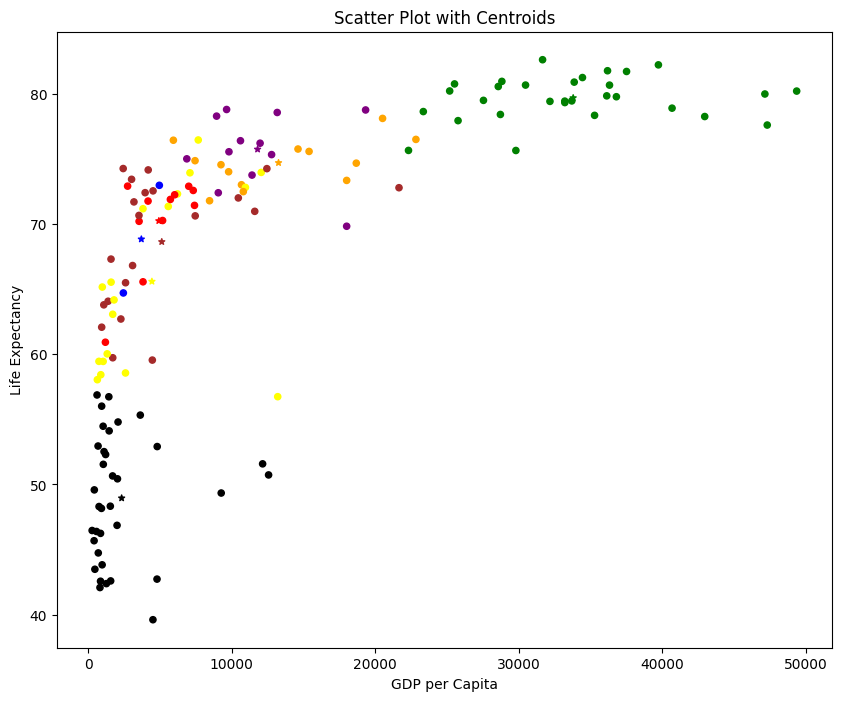

In [ ]:

colors = ["red", "green", "blue", "yellow", "purple", "orange", "black", "brown"]
df['color'] = df['labels'].map(lambda p: colors[p])

plt.figure(figsize=(7, 7))

# Scatter plot of data points
ax = df.plot(
    kind="scatter",
    x="gdpPercap", y="lifeExp",  # Updated column names
    figsize=(10, 8),
    c=df['color']
)


unscaled_centroids_df.plot(
    kind="scatter",
    x="gdpPercap", y="lifeExp",  # Updated column names
    marker="*", c=colors,
    ax=ax
)

plt.title("Scatter Plot with Centroids")
plt.xlabel("GDP per Capita")
plt.ylabel("Life Expectancy")
plt.show()

#### Evaluate using the silhoutte score

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming you have clustered data using KMeans and obtained labels
silhouette_avg = silhouette_score(df_transformed, df['labels'])
print(f"Silhouette Score: {silhouette_avg:.4f}")


Silhouette Score: 0.4212


#### Try other values for K

In [ ]:
#i asked chatGPT for help cause this lab took me forever.  Undoing the column

wcss = []  # List to store WCSS values

for k in range(1, 11):  # Try different values of k
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df_transformed)
    wcss.append(kmeans.inertia_)


#### Make an elbow plot of the silhoutte scores

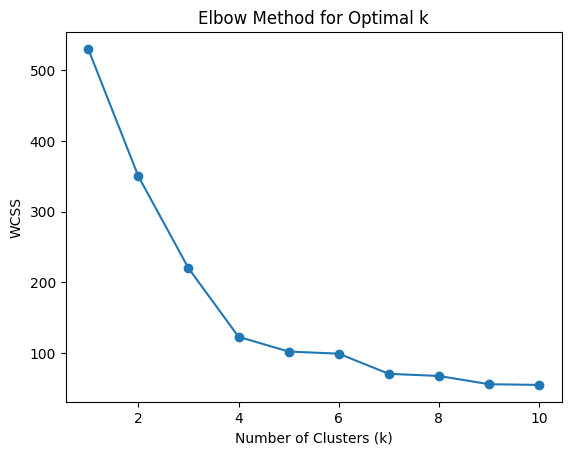

In [ ]:
ks = range(1, 11)  # Values of k
plt.plot(ks, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()


####  What's the best number of clusters?

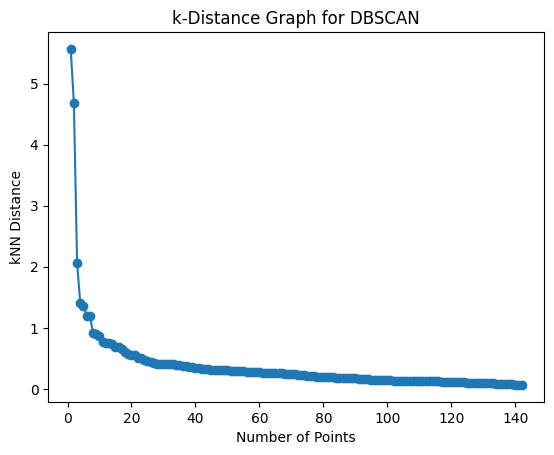

In [ ]:
#i think i got it right with 7knn = NearestNeighbors(n_neighbors=4)  # Choose k+1 neighbors (including the point itself)


---
## Part 2 DBSCAN

#### Use DBSCAN to cluster

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=2.0)

#### Explore and visualize your clustering results

In [ ]:
dbscan.fit(df_transformed)

DBSCAN(eps=2.0)

In [ ]:
silhouette_score(df_transformed, dbscan.labels_)

0.7404359560759209

In [ ]:
orig_df['cluster'] = dbscan.labels_

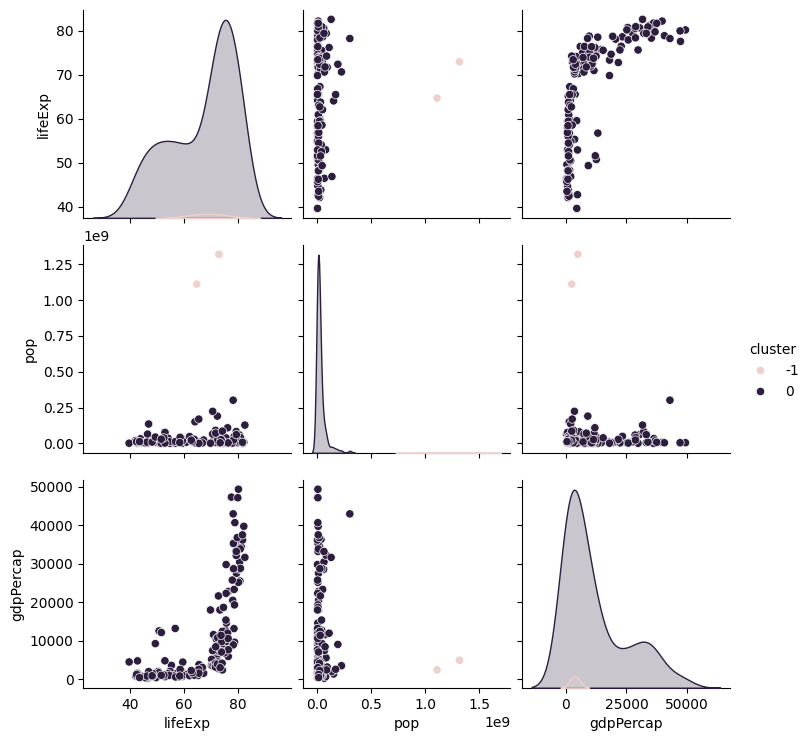

In [ ]:
sns.pairplot(orig_df, hue='cluster')

#### Hyperparameter tune 

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn = NearestNeighbors(n_neighbors=4)
knn.fit(df_transformed)
distances, _ = knn.kneighbors(df_transformed)
knn_distances = np.mean(distances[:, 1:], axis=1)  # Exclude the first column (distance to itself)

# Plot the k-distance graph
plt.plot(np.arange(1, len(df_transformed) + 1), np.sort(knn_distances)[::-1], marker='o')
plt.xlabel("Number of Points")
plt.ylabel("kNN Distance")
plt.title("k-Distance Graph for DBSCAN")
plt.show()

#### What are your best hyperparameters?

In [ ]:
#right around eps = 2

---

### Analysis
#### Which algorithm with which hyperparameters would you use to cluster a new country? Why?

I think Kmeans really does a much better job of capturing pieces of the information: continent, population, income ect.  Even if the scores are lower, i think it does a better job.  

## Bonus 🎉

Try a clustering algorithm we didn't cover in class. Scikit-learn has a guide to its clustering algorithms [here](https://scikit-learn.org/stable/modules/clustering.html).